# Simple state space model for voting intention (using pymc)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-setup" data-toc-modified-id="Python-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python setup</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#A-Bayesian-poll-aggregation-model-(pooling-polls)" data-toc-modified-id="A-Bayesian-poll-aggregation-model-(pooling-polls)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>A Bayesian poll aggregation model (pooling polls)</a></span><ul class="toc-item"><li><span><a href="#Supporting-functions" data-toc-modified-id="Supporting-functions-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Supporting functions</a></span></li><li><span><a href="#Analysis-frame" data-toc-modified-id="Analysis-frame-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Analysis frame</a></span></li><li><span><a href="#And-do-it-..." data-toc-modified-id="And-do-it-...-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>And do it ...</a></span></li></ul></li><li><span><a href="#Exploratory" data-toc-modified-id="Exploratory-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Exploratory</a></span></li><li><span><a href="#Other" data-toc-modified-id="Other-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Other</a></span></li></ul></div>

## Python setup

In [1]:
# data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# pymc probabilistic programming
import arviz as az
import pymc as pm

# system imports
from pathlib import Path
from io import StringIO

# local imports
import common
from common import COLOR_COALITION, COLOR_LABOR, COLOR_OTHER

In [2]:
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Thu May 19 2022 10:25:36

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.3.0

arviz     : 0.12.1
pandas    : 1.4.2
pymc      : 4.0.0b6
numpy     : 1.22.3
matplotlib: 3.5.2

Watermark: 2.3.0



In [3]:
# pymc set-up
az.style.use("arviz-darkgrid")

In [4]:
# plotting stuff
plt.style.use('./markgraph.mplstyle')

In [5]:
# path to the model data 
DATA_DIR = '../data/'
Path(DATA_DIR).mkdir(parents=True, exist_ok=True)

In [6]:
CHART_DIR = '../charts/'
Path(CHART_DIR).mkdir(parents=True, exist_ok=True)

## Load data

In [7]:
# Analysis based on this data ...
data_file = f'{DATA_DIR}primary_vote.csv' # f'{DATA_DIR}two_party_preferred.csv'


# Minimum polls requirement for a pollster
MIMIMUM_POLLS_FROM_POLLSTER = 2
# The one ANU poll since 2019 look like a rogue outlier, so let's exclude it

# Plot left-side footnotes
LFOOTER = (
    'Polling data from Wikipedia; '
    f'Pollsters ignored with < {MIMIMUM_POLLS_FROM_POLLSTER} polls'
)

In [8]:
# Check the data file has been updated today
common.check_file_current(data_file, 
    'Make sure you run the data capture notebook first')

In [9]:
# read in 2pp data; remind me, what are the column names ...
tpp = pd.read_csv(data_file, parse_dates=['Mean Date'], index_col=0)
tpp['Mean Date'] = pd.to_datetime(tpp['Mean Date'])
tpp = tpp.sort_values('Mean Date')
tpp.columns

Index(['Primary vote L/NP', 'Primary vote ALP', 'Primary vote GRN',
       'Primary vote ONP', 'Primary vote UAP', 'Primary vote OTH', 'Date',
       'Mean Date', 'Brand', 'Interview mode', 'Sample size',
       'Calculated 2pp L/NP', 'Calculated 2pp ALP'],
      dtype='object')

In [10]:
# latest poll
tpp['Mean Date'].max()

Timestamp('2022-05-15 00:00:00')

In [11]:
# last 5 polls
tpp.tail(8)

,Primary vote L/NP,Primary vote ALP,Primary vote GRN,Primary vote ONP,Primary vote UAP,Primary vote OTH,Date,Mean Date,Brand,Interview mode,Sample size,Calculated 2pp L/NP,Calculated 2pp ALP
148,36.000000,38.000000,11.000000,5.000000,4.000000,6.000000,27–30 Apr 2022,2022-04-28,Newspoll-YouGov,Online,1538.0,46.744000,53.256000
149,31.182796,37.634409,12.903226,4.301075,3.225806,10.752688,4–7 May 2022,2022-05-05,Ipsos,Telephone/online,2311.0,43.653763,56.346237
150,35.000000,39.000000,11.000000,5.000000,4.000000,6.000000,4–7 May 2022,2022-05-05,Newspoll-YouGov,Online,1523.0,45.745000,54.255000
151,34.000000,35.500000,13.000000,4.000000,1.000000,12.500000,2–8 May 2022,2022-05-05,Roy Morgan,Telephone/online,1401.0,45.701500,54.298500
152,35.000000,38.000000,11.000000,6.000000,3.000000,7.000000,10–13 May 2022,2022-05-11,Newspoll-YouGov,Online,1532.0,46.239000,53.761000
153,34.000000,34.000000,13.000000,4.000000,1.000000,14.000000,9–15 May 2022,2022-05-12,Roy Morgan,Telephone/online,1366.0,46.441000,53.559000
154,34.343434,31.313131,14.141414,6.060606,4.040404,10.101010,12–17 May 2022,2022-05-14,Resolve Strategic,Telephone/online,2049.0,48.387879,51.612121
155,38.709677,37.634409,9.677419,4.301075,3.225806,6.451613,14–16 May 2022,2022-05-15,Essential,Online,1600.0,48.478495,51.521505


In [12]:
# Combine the other primary vote in the main dataframe
OTHER = 'Other Combined Primary'
tpp[OTHER] = tpp[['Primary vote ONP', 'Primary vote UAP', 'Primary vote OTH']].fillna(0).sum(axis=1)

In [13]:
# Number of polls
len(tpp)

156

In [14]:
# Number of polls from each pollster
brand_counts = tpp['Brand'].value_counts()
brand_counts

Newspoll-YouGov      51
Essential            51
Roy Morgan           36
Resolve Strategic    14
Ipsos                 3
ANU                   1
Name: Brand, dtype: int64

In [15]:
# Remove pollsters with minimal polling history
keep = brand_counts[brand_counts >= MIMIMUM_POLLS_FROM_POLLSTER].index
tpp = tpp[tpp['Brand'].isin(keep)]
tpp['Brand'].value_counts()

Newspoll-YouGov      51
Essential            51
Roy Morgan           36
Resolve Strategic    14
Ipsos                 3
Name: Brand, dtype: int64

In [16]:
len(tpp)

155

## A Bayesian poll aggregation model (pooling polls)

### Supporting functions

In [17]:
def prepare_data_for_analysis(df, column):
    
    # make sure data is in date order
    assert df['Mean Date'].is_monotonic_increasing, 'Data must be in ascending date order'

    # get our zero centered observations
    y = df[column]
    centre_offset = -y.mean()
    zero_centered_y = y + centre_offset
    n_polls = len(zero_centered_y) ###
    
    # get our day-date mapping
    day_zero = df['Mean Date'].min()
    n_days = int((df['Mean Date'].max() - day_zero) / pd.Timedelta(days=1)) + 1
    poll_day = ((df['Mean Date'] - day_zero) / pd.Timedelta(days=1)).astype(int)
    
    # get our poll-branding information
    poll_brand = df.Brand.astype('category').cat.codes
    n_brands = len(poll_brand.unique())
    brand_map = {code: brand for brand, code in zip(df.Brand, poll_brand)}

    # measurement error 
    assumed_sample_size = 1000
    measurement_error_sd = np.sqrt((50 * 50) / assumed_sample_size)
    
    # Information
    print(f'Series: {column}\n'
          f'Number of polls: {n_polls}\n'
          f'Number of days: {n_days}\n'
          f'Number of pollsters: {n_brands}\n'
          f'Centre offset: {centre_offset}\n')

    return (zero_centered_y, centre_offset, n_polls, n_days, day_zero, 
            poll_day, poll_brand, brand_map, n_brands, measurement_error_sd)

In [18]:
def define_model(n_brands, n_days, poll_brand, 
                 zero_centered_y, 
                 measurement_error_sd):
    """PyMC model for pooling/aggregating voter opinion polls"""
    
    model = pm.Model()
    with  model:
        # priors 
        unanchored_house_bias = pm.Cauchy("unanchored_house_bias", 
                                          alpha=0, beta=10, shape=n_brands)
        zero_sum_house_bias = pm.Deterministic('zero_sum_house_bias', 
            var=(unanchored_house_bias - unanchored_house_bias.mean()))
        
        # temporal model
        DRIFT = 0.0
        INNOVATION = 0.15 # from experience ... day-to-day change distribution sigma
        EARLY_DATA_ITEMS = 5 
        SIGMA = 2.0
        educated_guess = zero_centered_y[:min(EARLY_DATA_ITEMS, len(zero_centered_y))].mean()
        start_dist = pm.Normal.dist(mu=educated_guess, sigma=SIGMA)
        grw = pm.GaussianRandomWalk('grw', mu=DRIFT, sigma=INNOVATION, 
                                    init=start_dist, steps=n_days) ### FAILS HERE
    
        # the observational model
        observed = pm.Normal("observed", 
                             mu=grw[poll_day.values] 
                                + zero_sum_house_bias[poll_brand.values],
                             sigma=measurement_error_sd, observed=zero_centered_y)
    return model

In [19]:
def draw_samples(model):
    N_CORES = 8
    with model:
        trace = pm.sample(1000, tune=1000, progressbar=True, 
                          cores=N_CORES, chains=N_CORES,
                          return_inferencedata=True)
        summary = az.summary(trace) # used below
        az.plot_trace(trace)      
        
    return trace, summary

In [20]:
def get_var_as_frame(inferencedata, variable_name):
    """Return a dataframe - column(s) are variables - rows are draws"""
    return pd.DataFrame(
        inferencedata
        .posterior
        .stack(draws=("chain", "draw"))[variable_name]
        .values
        .T
    )

def quants_and_mean(frame, quants):
    """Return a DataFrame - columns are quants and mean - rows are variable"""
    results = frame.quantile(quants).T
    results['mean'] = frame.mean()
    return results


def get_quant_iterator(quants):
    """get iterator for paired quantiles, with matching labels"""
    length = len(quants)
    assert length > 0, 'Quantile list should not be empty'
    assert (length % 2 == 0), 'Quantile list must have an even number of members'
    assert pd.Series(quants).is_monotonic_increasing, 'Qantiles must be ascending ordered'
    middle = int(length / 2)
    start = quants[:middle]
    stop = quants[-1:(middle-1):-1]
    label = (
        ((pd.Series(stop) - pd.Series(start)) * 100)
        .round(0)
        .astype(int)
        .astype(str)
        + '% HDI'
    ).to_list()
    return zip(start, stop, label)

In [21]:
QUANTS = (0.025, 0.1, 0.25, 0.75, 0.9, 0.975)
def plot_aggregation(trace, df, column, day_zero, n_days, centre_offset, 
                     point_color, line_color, title):
    
    # get the data
    grw = get_var_as_frame(trace, 'grw') - centre_offset
    grw.columns = pd.date_range(start=day_zero, periods=n_days+1)
    grw_summary = quants_and_mean(grw, QUANTS)
    
    # plot
    fig, axes = common.initiate_plot()
    axes.plot(grw_summary.index, grw_summary['mean'], 
            lw=2.0, c=line_color, 
            label='Mean Estimated Voting Intention')
    alpha = 0.1
    for start, stop, label in get_quant_iterator(QUANTS):
        axes.fill_between(x=grw_summary.index, y1=grw_summary[start], 
                        y2=grw_summary[stop], color=line_color, 
                        alpha=alpha, label=label)
        alpha += 0.1
    common.annotate_endpoint(axes, grw_summary['mean'])

    common.add_data_points_by_pollster(ax=axes, df=df, column=column,
                                      p_color=point_color, )
    common.add_h_refence(axes, 50)
    axes.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    lfooter = LFOOTER
    if '2pp' in title:
        lfooter += '; 2pp calculated from primary votes and 2019 preference flows'
    axes.legend(loc='best', ncol=2)
    full_title = f'Gaussian Random Walk - {title} Voting Intention'
    common.plot_finalise(axes,
                         title=full_title,
                         lfooter=lfooter)

In [22]:
def plot_house_effects(trace, brand_mapping, title, point_color, line_color):
    
    # get the relevant data
    zshb = get_var_as_frame(trace, 'zero_sum_house_bias')
    print(zshb.columns)
    zshb.columns =  zshb.columns.map(brand_mapping)
    zshb_summary = quants_and_mean(zshb, QUANTS)

    # and plot it
    fig, ax = common.initiate_plot()
    alpha = 0.1
    for start, stop, label in get_quant_iterator(QUANTS):
        ax.barh(zshb_summary.index, 
                width=zshb_summary[stop]-zshb_summary[start], 
                left=zshb_summary[start], 
                color=line_color, alpha=alpha, label=label)
        alpha += 0.1
    ax.scatter(zshb_summary['mean'], zshb_summary.index, 
               s=50, marker='o', color=point_color, label='Mean estimate')
    xlabel = f'Relative percentage point bias to {title.split()[0]}'
    full_title = f'Zero Sum Pollster Effects - {title}'
    ax.legend(loc='best')
    common.plot_finalise(ax,
                         title=full_title,
                         xlabel=xlabel,
                         lfooter=LFOOTER)

### Analysis frame

In [23]:
analytic_frame = f"""
column, title, point_color, line_color
Calculated 2pp L/NP, Coalition 2pp,     {common.P_COLOR_COALITION}, {common.COLOR_COALITION}
Primary vote L/NP,   Coalition Primary, {common.P_COLOR_COALITION}, {common.COLOR_COALITION}
Primary vote ALP,    Labor Primary,     {common.P_COLOR_LABOR},     {common.COLOR_LABOR}
Primary vote GRN,    Greens Primary,    {common.P_COLOR_GREEN},     {common.COLOR_GREEN}
{OTHER},             Others Primary,    {common.P_COLOR_OTHER},     {common.COLOR_OTHER}

"""

analytic_frame = pd.read_csv(StringIO(analytic_frame), skipinitialspace=True)
analytic_frame

,column,title,point_color,line_color
0,Calculated 2pp L/NP,Coalition 2pp,#0000dd,darkblue
1,Primary vote L/NP,Coalition Primary,#0000dd,darkblue
2,Primary vote ALP,Labor Primary,#dd0000,#dd0000
3,Primary vote GRN,Greens Primary,green,darkgreen
4,Other Combined Primary,Others Primary,orange,darkorange


### And do it ...

Coalition 2pp
Series: Calculated 2pp L/NP
Number of polls: 155
Number of days: 1025
Number of pollsters: 5
Centre offset: -48.22283073626935



/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/pymc/initial_point.py:281: UserWarning: Moment not defined for variable grw of type GaussianRandomWalkRV, defaulting to a draw from the prior. This can lead to difficulties during tuning. You can manually define an initval or implement a moment dispatched function for this distribution.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/pymc/initial_point.py:281: UserWarning: Moment not defined for variable grw of type GaussianRandomWalkRV, defaulting to a draw from the prior. This can lead to difficulties during tuning. You can manually define an initval or implement a moment dispatched function for this distribution.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/pymc/initial_point.py:281: UserWarning: Moment not defined for variable grw of type GaussianRandomWalkRV, default

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 79 seconds.


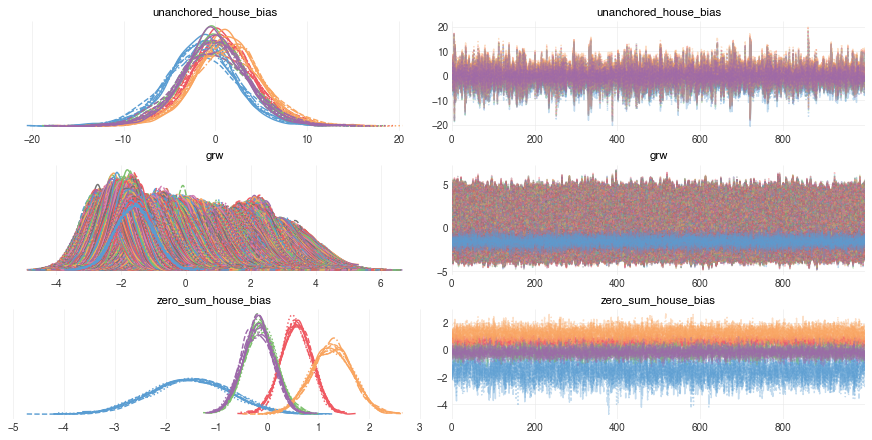

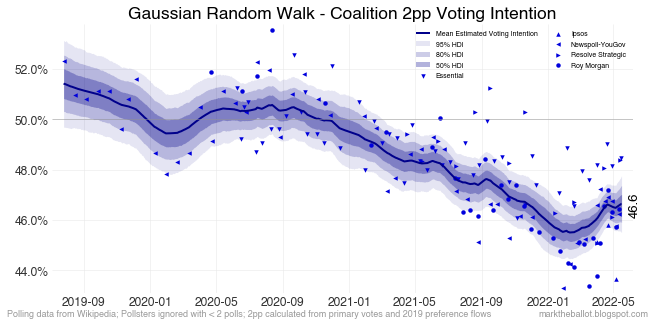

RangeIndex(start=0, stop=5, step=1)


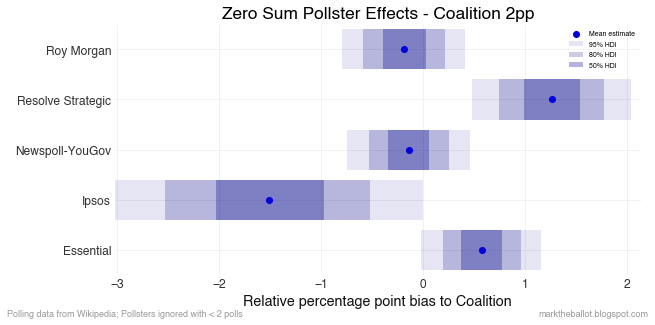

Coalition Primary
Series: Primary vote L/NP
Number of polls: 155
Number of days: 1025
Number of pollsters: 5
Centre offset: -38.95438007990834



/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/pymc/initial_point.py:281: UserWarning: Moment not defined for variable grw of type GaussianRandomWalkRV, defaulting to a draw from the prior. This can lead to difficulties during tuning. You can manually define an initval or implement a moment dispatched function for this distribution.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [unanchored_house_bias, grw]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 76 seconds.


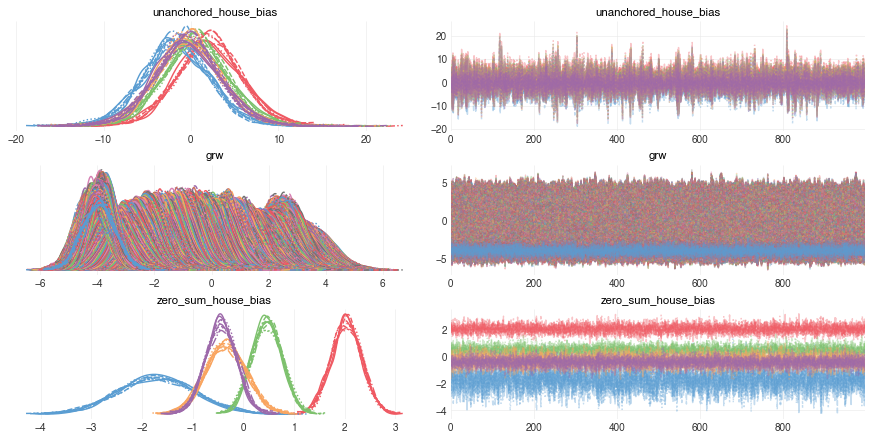

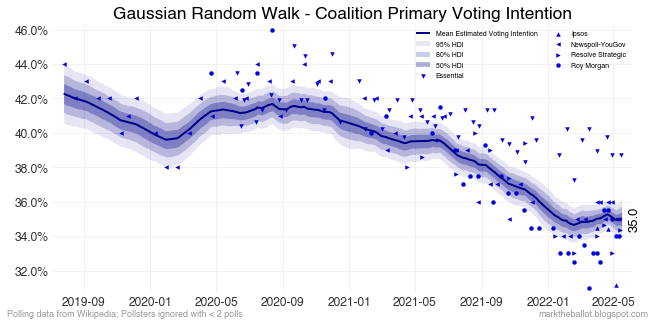

RangeIndex(start=0, stop=5, step=1)


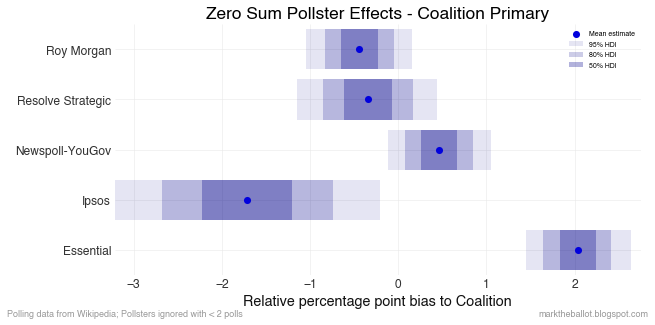

Labor Primary
Series: Primary vote ALP
Number of polls: 155
Number of days: 1025
Number of pollsters: 5
Centre offset: -36.548792230285564



/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/pymc/initial_point.py:281: UserWarning: Moment not defined for variable grw of type GaussianRandomWalkRV, defaulting to a draw from the prior. This can lead to difficulties during tuning. You can manually define an initval or implement a moment dispatched function for this distribution.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [unanchored_house_bias, grw]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 77 seconds.


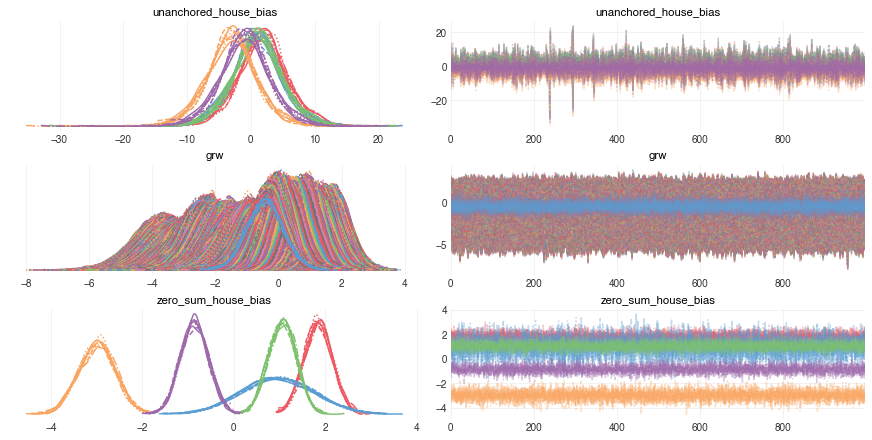

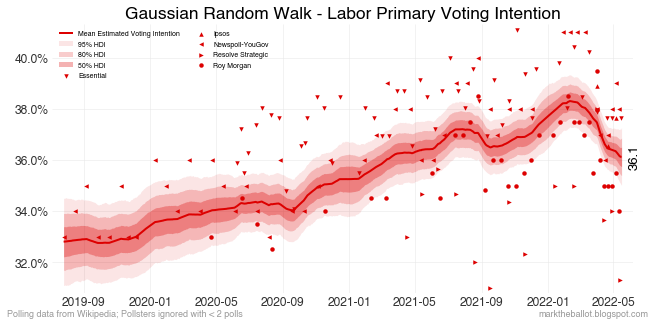

RangeIndex(start=0, stop=5, step=1)


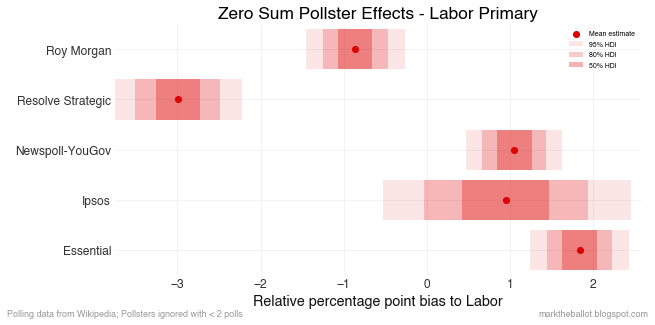

Greens Primary
Series: Primary vote GRN
Number of polls: 155
Number of days: 1025
Number of pollsters: 5
Centre offset: -10.998436696481226



/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/pymc/initial_point.py:281: UserWarning: Moment not defined for variable grw of type GaussianRandomWalkRV, defaulting to a draw from the prior. This can lead to difficulties during tuning. You can manually define an initval or implement a moment dispatched function for this distribution.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [unanchored_house_bias, grw]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 80 seconds.


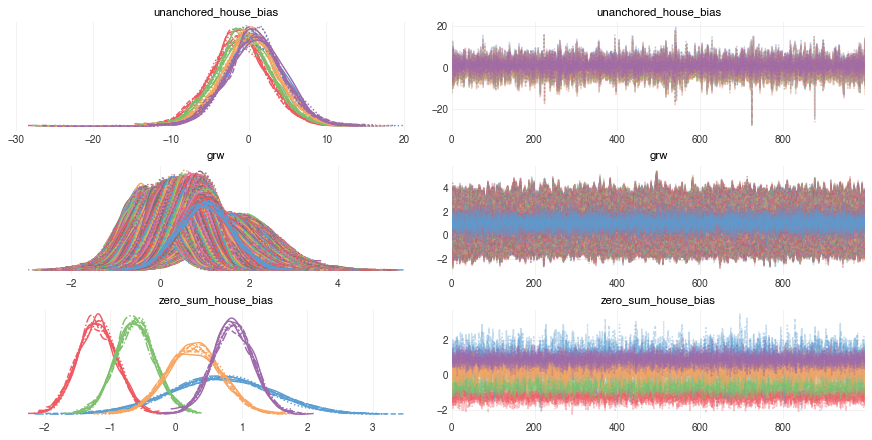

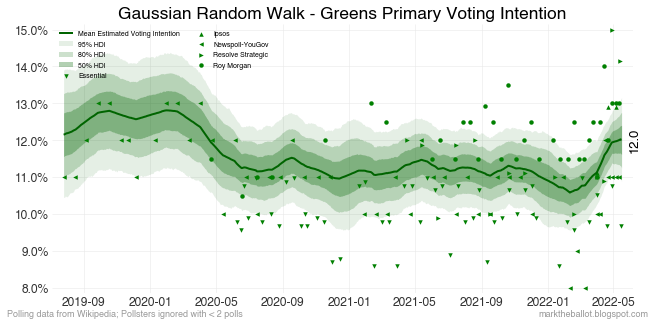

RangeIndex(start=0, stop=5, step=1)


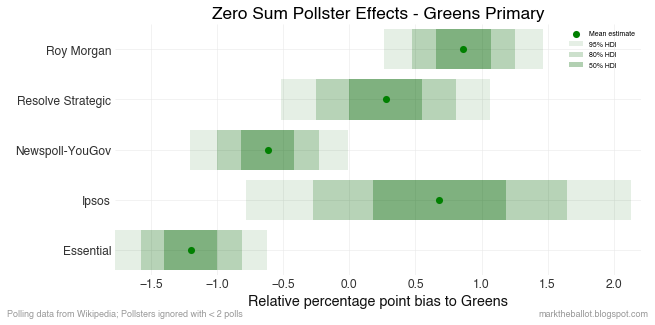

Others Primary
Series: Other Combined Primary
Number of polls: 155
Number of days: 1025
Number of pollsters: 5
Centre offset: -13.498390993324861



/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/pymc/initial_point.py:281: UserWarning: Moment not defined for variable grw of type GaussianRandomWalkRV, defaulting to a draw from the prior. This can lead to difficulties during tuning. You can manually define an initval or implement a moment dispatched function for this distribution.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [unanchored_house_bias, grw]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 79 seconds.


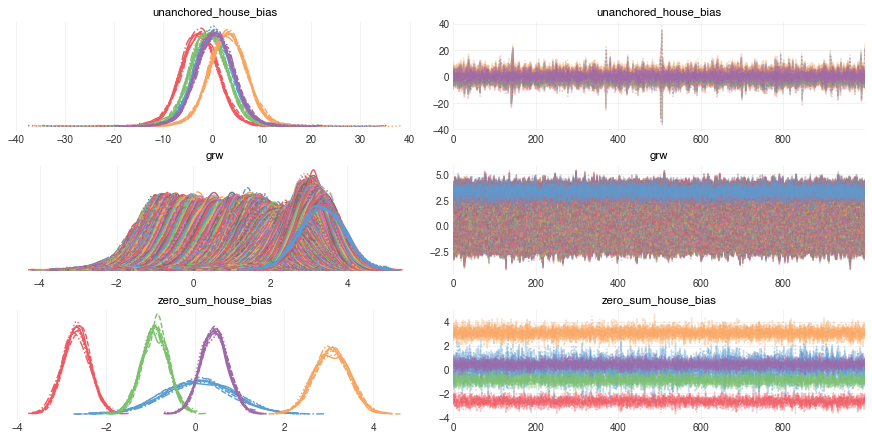

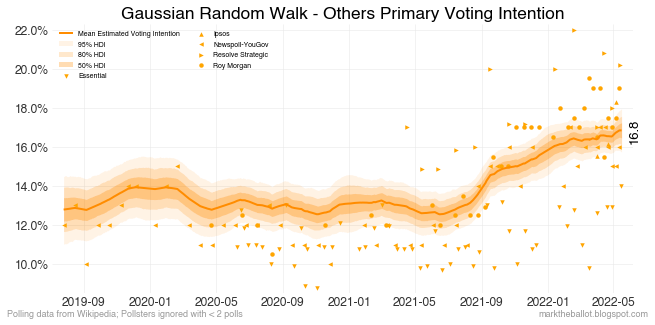

RangeIndex(start=0, stop=5, step=1)


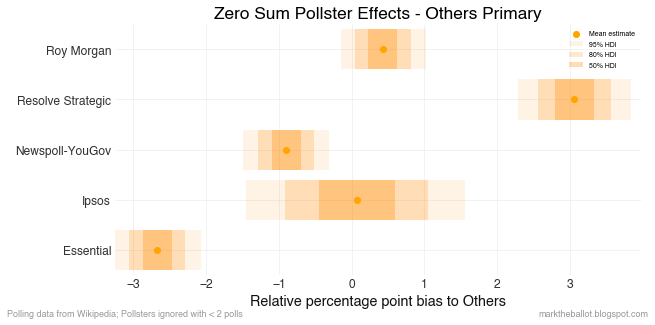

In [24]:
for index, series in analytic_frame.iterrows():
    print(series['title'])
    
    (zero_centered_y, centre_offset, n_polls, n_days, day_zero, poll_day, 
        poll_brand, brand_map, n_brands, measurement_error_sd) = (
        prepare_data_for_analysis(tpp, series['column']))
    
    model = define_model(n_brands, n_days, poll_brand, zero_centered_y,
                         measurement_error_sd)
    
    trace, summary = draw_samples(model)
    
    plot_aggregation(trace, tpp, series['column'], day_zero, n_days, 
                     centre_offset, series['point_color'], 
                     series['line_color'], series['title'])
    
    plot_house_effects(trace, brand_map, series['title'], 
                       series['point_color'], series['line_color'])

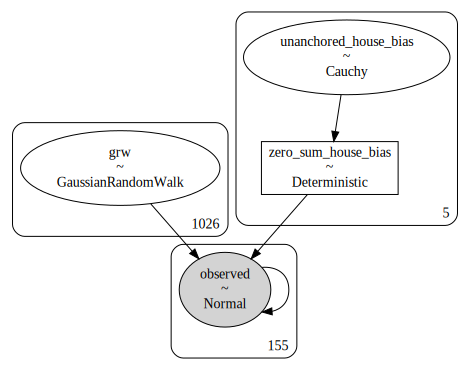

In [ ]:
pm.model_to_graphviz(model)

## Exploratory

## Other

In [ ]:
common.print_warnings()